In [2]:
#load library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from tqdm.auto import tqdm
from nltk.corpus import stopwords
tqdm.pandas()

In [4]:
#load dataset
df = pd.read_csv('dataset_reduced_30.csv', encoding = 'utf-8',)
df.head()

,text,labels
0,akom gerilya serta musyawarah luar biasa leseh...,0
1,bukan kisah dik kisah yang kutip bukan band ya...,0
2,tidak kak orang jawa maaf ya orang palembang k...,0
3,titit jemaah dum camping,0
4,cinta buta cinta murni luhur buta cinta kuasa ...,0


In [5]:
#pastikan tipe data pada kolom text dan labels
df['text'] = df['text'].astype(str)
df['labels'] = df['labels'].astype(int)

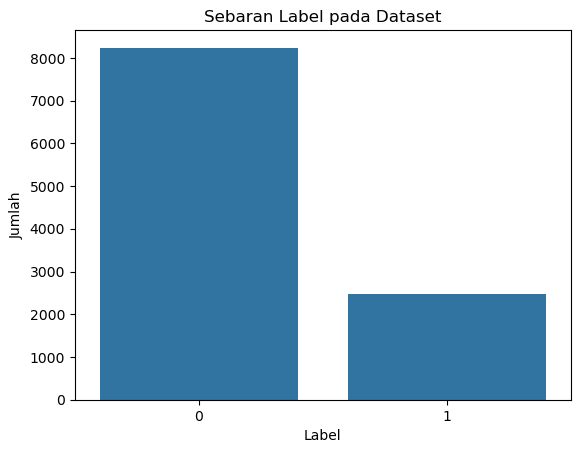

labels
0    8237
1    2471
Name: count, dtype: int64

In [6]:
#lihat sebaran label pada dataset
sns.countplot(x='labels', data=df)
plt.title('Sebaran Label pada Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()
#Cek jumlah data pada setiap label
df['labels'].value_counts()

In [7]:
# untuk test hasil model terhadap dataset super imbalanced, dosbim meminta untuk mengurangi jumlah label data 1 menjadi 10% dari label 0
# Mengurangi jumlah label 1 menjadi 10% dari label 0
def reduce_label_1(df, target_ratio=0.1):
    count_0 = df[df['labels'] == 0].shape[0]
    count_1 = df[df['labels'] == 1].shape[0]
    
    # Hitung jumlah label 1 yang diinginkan
    target_count_1 = int(count_0 * target_ratio)
    
    # Ambil subset dari label 1
    df_label_1 = df[df['labels'] == 1].sample(n=target_count_1, random_state=42)
    
    # Gabungkan dengan label 0
    df_reduced = pd.concat([df[df['labels'] == 0], df_label_1])
    
    return df_reduced

***PERSIAPKAN WORD-EMBEDDING FASTTEXT***

In [8]:
#load model pre-trained FastText
model_path = 'cc.id.300.bin'

import fasttext
ft_model = fasttext.load_model(model_path)

print(ft_model.get_dimension())
print(ft_model.get_word_vector("saya")[:10])  # Cek vektor kata

300
[-0.01407608  0.06523435  0.04372576  0.18425423  0.02241408 -0.11397391
 -0.04704365  0.02331188 -0.02006736 -0.05753721]


In [9]:
df = df.dropna(subset=['text'])

In [10]:
#definisikan X dan y
X = df['text'].tolist()
y = df['labels'].values

#tokenisasi teks
max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(f"Jumlah kata unik dalam kamus: {len(word_index)}")

# Mengonversi teks menjadi urutan indeks
sequences = tokenizer.texts_to_sequences(X)

# Padding urutan untuk memastikan panjang yang konsisten
maxlen = max(len(seq) for seq in sequences)
print(f"Panjang maksimum urutan: {maxlen}")

# Padding urutan
X_padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

Jumlah kata unik dalam kamus: 12354
Panjang maksimum urutan: 52


Text(0.5, 1.0, 'Distribusi Panjang Teks')

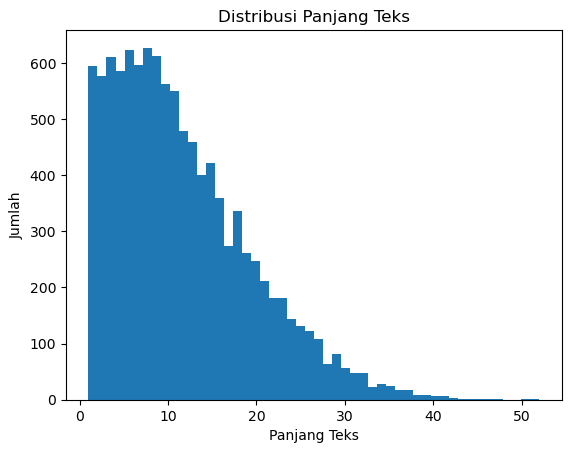

In [11]:
#analisis distribusi panjang kata untuk maxlen
plt.hist([len(seq) for seq in sequences], bins=50)
plt.xlabel('Panjang Teks'); plt.ylabel('Jumlah'); plt.title('Distribusi Panjang Teks')

In [12]:
# Membuat matriks embedding
embedding_dim = ft_model.get_dimension()
num_tokens = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_tokens, embedding_dim))
words_not_found = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    embedding_matrix[i] = ft_model.get_word_vector(word)

print(f"Dimensi matriks embedding: {embedding_matrix.shape}")

Dimensi matriks embedding: (12355, 300)


***DEFINISIKAN ARSITEKTUR MODEL BiLSTM***

In [13]:
# Definisikan hyperparameter untuk model LSTM
lstm_units = 128                                    # Jumlah unit LSTM
dense_units = 64                                    # Jumlah unit pada lapisan dense
dropout_rate = 0.5                                  # Tingkat dropout untuk regularisasi
learning_rate = 0.001                               # Tingkat pembelajaran awal untuk optimizer Adam
epochs = 10                                         # Jumlah epoch pelatihan
batch_size = 64                                     # Ukuran batch untuk pelatihan

In [14]:
# Bangun model LSTM
def build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate):
    model = Sequential()
    
    model.add(Embedding(input_dim=num_tokens,
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=maxlen,
                        trainable=False))
    
    #Lapisan BiLSTM untuk menangkap konteks dari kedua arah
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan Dense dengan aktivasi ReLU
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout untuk regularisasi

    #Lapisan output dengan aktivasi sigmoid untuk klasifikasi biner
    model.add(Dense(1, activation='sigmoid'))

    return model

# Inisialisasi model
model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
# Bangun model secara eksplisit dengan menentukan input_shape
model.build(input_shape=(None, maxlen))
model.summary()

c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 52, 300)        │     3,706,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,162,309 (15.88 MB)

 Trainable params: 455,809 (1.74 MB)

 Non-trainable params: 3,706,500 (14.14 MB)

In [15]:
# Compile model
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),]

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)
print("Model telah dicompile.")

Model telah dicompile.


***PELATIHAN DAN EVALUASI MODEL***

In [16]:
#Definisikan X dan y untuk model pelatihan dan evaluasi
X_cv = X_padded
y_cv = y

print(f"Total data instances for Cross-Validation: {len(X_cv)}")
print(f"Overall data distribution for Cross-Validation: {Counter(y_cv)}")

Total data instances for Cross-Validation: 10708
Overall data distribution for Cross-Validation: Counter({0: 8237, 1: 2471})


In [17]:
#Definisikan Fungsi untuk Melatih dan Mengevaluasi Model pada Satu Fold
def train_and_evaluate_single_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold_idx, technique_name):
    print(f"\n===== Training and Evaluating {technique_name} - Fold {fold_idx+1} =====")
    
    # Rebuild model to ensure fresh weights for each fold
    model = build_lstm_model(num_tokens, embedding_dim, maxlen, embedding_matrix, lstm_units, dense_units, dropout_rate)
    model.build(input_shape=(None, maxlen))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # Metrik untuk kompilasi model di dalam fungsi ini
    METRICS_FOLD = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'), 
        tf.keras.metrics.Recall(name='recall'),
    ]
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=METRICS_FOLD)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True, verbose=1) 
    
    # Pastikan tipe data numerik yang benar untuk TensorFlow
    X_train_fold = X_train_fold.astype(np.float32)
    y_train_fold = y_train_fold.astype(np.int32)
    X_val_fold = X_val_fold.astype(np.float32)
    y_val_fold = y_val_fold.astype(np.int32)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_fold, y_val_fold), # Gunakan validation_data langsung 
                        callbacks=[early_stopping], # Tambahkan callback EarlyStopping di sini
                        verbose=1)
    
    # Make predictions on the validation fold
    y_pred_prob = model.predict(X_val_fold)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics for this fold
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, zero_division=0)
    recall = recall_score(y_val_fold, y_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, zero_division=0)
    
    print(f"Fold {fold_idx+1} Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'y_true': y_val_fold, 'y_pred': y_pred}


--- Starting 5-Fold Cross-Validation for Random Oversampling ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (Random Oversampling): Counter({0: 6589, 1: 6589})

===== Training and Evaluating Random Oversampling - Fold 1 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - accuracy: 0.6516 - loss: 0.6143 - precision: 0.6463 - recall: 0.6582 - val_accuracy: 0.7918 - val_loss: 0.4357 - val_precision: 0.5372 - val_recall: 0.7024
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 51s 245ms/step - accuracy: 0.7740 - loss: 0.4792 - precision: 0.7610 - recall: 0.7985 - val_accuracy: 0.7190 - val_loss: 0.5244 - val_precision: 0.4421 - val_recall: 0.8340
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.8047 - loss: 0.4331 - precision: 0.7860 - recall: 0.8352 - val_accuracy: 0.8021 - val_loss: 0.4070 - val_precision: 0.5534 - val_recall: 0.7348
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - accuracy: 0.8256 - loss: 0.3953 - precision: 0.8077 - recall: 0.8540 - val_accuracy: 0.8049 - val_loss: 0.4073 - val_precision: 0.5605 - val_recall: 0.7126
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.8418 - loss: 0.3682 - precision: 0.8146 - recall: 0.8835 - val_accuracy: 0.7876

 20%|██        | 1/5 [05:01<20:07, 301.82s/it]

Fold 1 Metrics: Accuracy=0.8021, Precision=0.5534, Recall=0.7348, F1-Score=0.6313
Waktu untuk Random Oversampling: 301.84 detik
Fold 2 - Resampled training set distribution (Random Oversampling): Counter({0: 6589, 1: 6589})

===== Training and Evaluating Random Oversampling - Fold 2 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.6386 - loss: 0.6183 - precision: 0.6324 - recall: 0.6422 - val_accuracy: 0.7633 - val_loss: 0.4747 - val_precision: 0.4903 - val_recall: 0.6660
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 230ms/step - accuracy: 0.7791 - loss: 0.4740 - precision: 0.7725 - recall: 0.8001 - val_accuracy: 0.7656 - val_loss: 0.4714 - val_precision: 0.4946 - val_recall: 0.7389
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.7999 - loss: 0.4227 - precision: 0.7881 - recall: 0.8186 - val_accuracy: 0.7096 - val_loss: 0.5429 - val_precision: 0.4342 - val_recall: 0.8543
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.8225 - loss: 0.3889 - precision: 0.7992 - recall: 0.8587 - val_accuracy: 0.7264 - val_loss: 0.5585 - val_precision: 0.4515 - val_recall: 0.8664
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 227ms/step - accuracy: 0.8403 - loss: 0.3676 - precision: 0.8190 - recall: 0.8694 - val_accuracy: 0.7736 - val_loss

 40%|████      | 2/5 [09:05<13:23, 267.86s/it]

Fold 2 Metrics: Accuracy=0.7656, Precision=0.4946, Recall=0.7389, F1-Score=0.5925
Waktu untuk Random Oversampling: 545.94 detik
Fold 3 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 3 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 63s 268ms/step - accuracy: 0.6513 - loss: 0.6164 - precision: 0.6535 - recall: 0.5967 - val_accuracy: 0.7148 - val_loss: 0.5603 - val_precision: 0.4386 - val_recall: 0.8364
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - accuracy: 0.7808 - loss: 0.4683 - precision: 0.7690 - recall: 0.7965 - val_accuracy: 0.7535 - val_loss: 0.4972 - val_precision: 0.4802 - val_recall: 0.8101
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.7978 - loss: 0.4361 - precision: 0.7842 - recall: 0.8220 - val_accuracy: 0.7442 - val_loss: 0.4947 - val_precision: 0.4686 - val_recall: 0.8000
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 225ms/step - accuracy: 0.8211 - loss: 0.3992 - precision: 0.7985 - recall: 0.8606 - val_accuracy: 0.7507 - val_loss: 0.5057 - val_precision: 0.4773 - val_recall: 0.8283
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 254ms/step - accuracy: 0.8392 - loss: 0.3622 - precision: 0.8178 - recall: 0.8719 - val_accuracy: 0.7792

 60%|██████    | 3/5 [15:59<11:09, 334.59s/it]

Fold 3 Metrics: Accuracy=0.7792, Precision=0.5155, Recall=0.7394, F1-Score=0.6075
Waktu untuk Random Oversampling: 959.94 detik
Fold 4 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 4 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - accuracy: 0.6449 - loss: 0.6218 - precision: 0.6540 - recall: 0.5453 - val_accuracy: 0.6885 - val_loss: 0.5857 - val_precision: 0.4172 - val_recall: 0.8826
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 209ms/step - accuracy: 0.7691 - loss: 0.4795 - precision: 0.7602 - recall: 0.7976 - val_accuracy: 0.7403 - val_loss: 0.5043 - val_precision: 0.4643 - val_recall: 0.8158
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.8014 - loss: 0.4298 - precision: 0.7782 - recall: 0.8336 - val_accuracy: 0.8076 - val_loss: 0.4222 - val_precision: 0.5722 - val_recall: 0.6579
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.8196 - loss: 0.3979 - precision: 0.8003 - recall: 0.8523 - val_accuracy: 0.7595 - val_loss: 0.4879 - val_precision: 0.4871 - val_recall: 0.8016
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.8303 - loss: 0.3757 - precision: 0.8059 - recall: 0.8747 - val_accuracy: 0.7926 - val_loss

 80%|████████  | 4/5 [20:27<05:08, 308.34s/it]

Fold 4 Metrics: Accuracy=0.8076, Precision=0.5722, Recall=0.6579, F1-Score=0.6121
Waktu untuk Random Oversampling: 1228.02 detik
Fold 5 - Resampled training set distribution (Random Oversampling): Counter({0: 6590, 1: 6590})

===== Training and Evaluating Random Oversampling - Fold 5 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - accuracy: 0.6363 - loss: 0.6187 - precision: 0.6319 - recall: 0.6656 - val_accuracy: 0.7520 - val_loss: 0.5077 - val_precision: 0.4752 - val_recall: 0.7166
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - accuracy: 0.7747 - loss: 0.4833 - precision: 0.7669 - recall: 0.7864 - val_accuracy: 0.7632 - val_loss: 0.4918 - val_precision: 0.4911 - val_recall: 0.7227
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - accuracy: 0.7987 - loss: 0.4337 - precision: 0.7791 - recall: 0.8298 - val_accuracy: 0.7370 - val_loss: 0.5136 - val_precision: 0.4592 - val_recall: 0.7854
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.8201 - loss: 0.3930 - precision: 0.8030 - recall: 0.8538 - val_accuracy: 0.7637 - val_loss: 0.5457 - val_precision: 0.4915 - val_recall: 0.7004
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 52s 251ms/step - accuracy: 0.8381 - loss: 0.3694 - precision: 0.8191 - recall: 0.8719 - val_accuracy: 0.7515

100%|██████████| 5/5 [24:35<00:00, 295.12s/it]


Fold 5 Metrics: Accuracy=0.7632, Precision=0.4911, Recall=0.7227, F1-Score=0.5848
Waktu untuk Random Oversampling: 1475.62 detik

Average Metrics for Random Oversampling across 5 folds:
{'accuracy': 0.7835266817298303, 'precision': 0.5253337615708528, 'recall': 0.7187289903079377, 'f1_score': 0.6056250020979974, 'technique': 'Random Oversampling'}

--- Starting 5-Fold Cross-Validation for SMOTE ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (SMOTE): Counter({0: 6589, 1: 6589})

===== Training and Evaluating SMOTE - Fold 1 =====


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - accuracy: 0.5579 - loss: 0.6768 - precision: 0.5513 - recall: 0.7107 - val_accuracy: 0.6807 - val_loss: 0.5925 - val_precision: 0.3983 - val_recall: 0.7530
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 221ms/step - accuracy: 0.6602 - loss: 0.6096 - precision: 0.6530 - recall: 0.6644 - val_accuracy: 0.7157 - val_loss: 0.5349 - val_precision: 0.4341 - val_recall: 0.7672
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.7328 - loss: 0.5371 - precision: 0.7262 - recall: 0.7589 - val_accuracy: 0.7236 - val_loss: 0.5240 - val_precision: 0.4433 - val_recall: 0.7753
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.7608 - loss: 0.4967 - precision: 0.7528 - recall: 0.7719 - val_accuracy: 0.7386 - val_loss: 0.5094 - val_precision: 0.4593 - val_recall: 0.7530
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.7846 - loss: 0.4636 - precision: 0.7771 - recall: 0.7974 - val_accuracy: 0.7628

 20%|██        | 1/5 [06:41<26:47, 401.97s/it]

Fold 1 Metrics: Accuracy=0.7731, Precision=0.5058, Recall=0.7004, F1-Score=0.5874
Waktu untuk SMOTE: 401.97 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 2 - Resampled training set distribution (SMOTE): Counter({0: 6589, 1: 6589})

===== Training and Evaluating SMOTE - Fold 2 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 215ms/step - accuracy: 0.5518 - loss: 0.6792 - precision: 0.5444 - recall: 0.5078 - val_accuracy: 0.6662 - val_loss: 0.6046 - val_precision: 0.3920 - val_recall: 0.8117
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.6619 - loss: 0.6164 - precision: 0.6490 - recall: 0.7097 - val_accuracy: 0.6858 - val_loss: 0.5692 - val_precision: 0.4041 - val_recall: 0.7632
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - accuracy: 0.7185 - loss: 0.5501 - precision: 0.7065 - recall: 0.7420 - val_accuracy: 0.7204 - val_loss: 0.5351 - val_precision: 0.4371 - val_recall: 0.7389
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.7478 - loss: 0.5116 - precision: 0.7324 - recall: 0.7782 - val_accuracy: 0.7414 - val_loss: 0.5297 - val_precision: 0.4619 - val_recall: 0.7368
Epoch 5/10
206

 40%|████      | 2/5 [13:05<19:34, 391.36s/it]

Fold 2 Metrics: Accuracy=0.7470, Precision=0.4683, Recall=0.7186, F1-Score=0.5671
Waktu untuk SMOTE: 785.91 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 3 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 3 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.5616 - loss: 0.6759 - precision: 0.5714 - recall: 0.4860 - val_accuracy: 0.6410 - val_loss: 0.6144 - val_precision: 0.3729 - val_recall: 0.8121
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - accuracy: 0.6773 - loss: 0.6013 - precision: 0.6679 - recall: 0.7126 - val_accuracy: 0.6471 - val_loss: 0.5926 - val_precision: 0.3832 - val_recall: 0.8646
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.7306 - loss: 0.5344 - precision: 0.7134 - recall: 0.7628 - val_accuracy: 0.7199 - val_loss: 0.5572 - val_precision: 0.4377 - val_recall: 0.7455
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.7619 - loss: 0.4915 - precision: 0.7537 - recall: 0.7769 - val_accuracy: 0.7288 - val_loss: 0.5306 - val_precision: 0.4501 - val_recall: 0.7838
Epoch 5/10
206

 60%|██████    | 3/5 [19:40<13:05, 392.92s/it]

Fold 3 Metrics: Accuracy=0.7857, Precision=0.5285, Recall=0.6747, F1-Score=0.5927
Waktu untuk SMOTE: 1180.68 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 4 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 4 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 186ms/step - accuracy: 0.5448 - loss: 0.6803 - precision: 0.5355 - recall: 0.5254 - val_accuracy: 0.7128 - val_loss: 0.5632 - val_precision: 0.4292 - val_recall: 0.7429
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.6672 - loss: 0.6088 - precision: 0.6539 - recall: 0.7220 - val_accuracy: 0.6133 - val_loss: 0.6357 - val_precision: 0.3578 - val_recall: 0.8502
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.7224 - loss: 0.5500 - precision: 0.7141 - recall: 0.7432 - val_accuracy: 0.7212 - val_loss: 0.5641 - val_precision: 0.4385 - val_recall: 0.7429
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.7445 - loss: 0.5171 - precision: 0.7393 - recall: 0.7523 - val_accuracy: 0.7595 - val_loss: 0.4808 - val_precision: 0.4851 - val_recall: 0.6903
Epoch 5/10
206

 80%|████████  | 4/5 [24:23<05:49, 349.45s/it]

Fold 4 Metrics: Accuracy=0.7595, Precision=0.4851, Recall=0.6903, F1-Score=0.5698
Waktu untuk SMOTE: 1463.49 detik


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Fold 5 - Resampled training set distribution (SMOTE): Counter({0: 6590, 1: 6590})

===== Training and Evaluating SMOTE - Fold 5 =====
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.5474 - loss: 0.6829 - precision: 0.5493 - recall: 0.5249 - val_accuracy: 0.6707 - val_loss: 0.5875 - val_precision: 0.3942 - val_recall: 0.7955
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.6694 - loss: 0.6018 - precision: 0.6561 - recall: 0.7035 - val_accuracy: 0.6385 - val_loss: 0.6333 - val_precision: 0.3701 - val_recall: 0.8077
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.7340 - loss: 0.5380 - precision: 0.7200 - recall: 0.7818 - val_accuracy: 0.7202 - val_loss: 0.5368 - val_precision: 0.4357 - val_recall: 0.7206
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.7647 - loss: 0.4889 - precision: 0.7524 - recall: 0.7845 - val_accuracy: 0.6931 - val_loss: 0.5651 - val_precision: 0.4083 - val_recall: 0.7348
Epoch 5/10
206

100%|██████████| 5/5 [31:05<00:00, 373.02s/it]


Fold 5 Metrics: Accuracy=0.7539, Precision=0.4750, Recall=0.6336, F1-Score=0.5429
Waktu untuk SMOTE: 1865.12 detik

Average Metrics for SMOTE across 5 folds:
{'accuracy': 0.7638201037849359, 'precision': 0.49253855437160887, 'recall': 0.683532490900912, 'f1_score': 0.5719884482809696, 'technique': 'SMOTE'}

--- Starting 5-Fold Cross-Validation for ADASYN ---


  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 - Resampled training set distribution (ADASYN): Counter({1: 6857, 0: 6589})

===== Training and Evaluating ADASYN - Fold 1 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


211/211 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.5439 - loss: 0.6827 - precision: 0.5415 - recall: 0.7517 - val_accuracy: 0.6396 - val_loss: 0.5923 - val_precision: 0.3750 - val_recall: 0.8441
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.6628 - loss: 0.6121 - precision: 0.6470 - recall: 0.7533 - val_accuracy: 0.7278 - val_loss: 0.5304 - val_precision: 0.4454 - val_recall: 0.7348
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.7191 - loss: 0.5556 - precision: 0.7088 - recall: 0.7713 - val_accuracy: 0.7148 - val_loss: 0.5397 - val_precision: 0.4334 - val_recall: 0.7713
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 37s 177ms/step - accuracy: 0.7511 - loss: 0.5136 - precision: 0.7421 - recall: 0.7840 - val_accuracy: 0.7381 - val_loss: 0.5313 - val_precision: 0.4587 - val_recall: 0.7530
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.7838 - loss: 0.4573 - precision: 0.7805 - recall: 0.8026 - val_accuracy: 0.7610 - val_loss

 20%|██        | 1/5 [05:32<22:10, 332.52s/it]

Fold 1 Metrics: Accuracy=0.7610, Precision=0.4871, Recall=0.6903, F1-Score=0.5712
Waktu untuk ADASYN: 332.53 detik
Fold 2 - Resampled training set distribution (ADASYN): Counter({1: 6796, 0: 6589})

===== Training and Evaluating ADASYN - Fold 2 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


210/210 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - accuracy: 0.5554 - loss: 0.6796 - precision: 0.5577 - recall: 0.5537 - val_accuracy: 0.5593 - val_loss: 0.6812 - val_precision: 0.3272 - val_recall: 0.8623
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 49s 233ms/step - accuracy: 0.6692 - loss: 0.6052 - precision: 0.6567 - recall: 0.7358 - val_accuracy: 0.6704 - val_loss: 0.5769 - val_precision: 0.3905 - val_recall: 0.7652
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.7343 - loss: 0.5278 - precision: 0.7160 - recall: 0.7831 - val_accuracy: 0.7035 - val_loss: 0.5531 - val_precision: 0.4219 - val_recall: 0.7713
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 51s 243ms/step - accuracy: 0.7533 - loss: 0.5006 - precision: 0.7484 - recall: 0.7751 - val_accuracy: 0.7558 - val_loss: 0.5006 - val_precision: 0.4797 - val_recall: 0.6923
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 261ms/step - accuracy: 0.7846 - loss: 0.4586 - precision: 0.7855 - recall: 0.7954 - val_accuracy: 0.6900 - val_loss

 40%|████      | 2/5 [13:45<21:19, 426.64s/it]

Fold 2 Metrics: Accuracy=0.7983, Precision=0.5546, Recall=0.6377, F1-Score=0.5932
Waktu untuk ADASYN: 825.05 detik
Fold 3 - Resampled training set distribution (ADASYN): Counter({1: 6835, 0: 6590})

===== Training and Evaluating ADASYN - Fold 3 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


210/210 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.5415 - loss: 0.6827 - precision: 0.5389 - recall: 0.6677 - val_accuracy: 0.7194 - val_loss: 0.5894 - val_precision: 0.4332 - val_recall: 0.6949
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.6738 - loss: 0.6055 - precision: 0.6660 - recall: 0.7213 - val_accuracy: 0.6802 - val_loss: 0.5900 - val_precision: 0.4038 - val_recall: 0.8061
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.7279 - loss: 0.5347 - precision: 0.7182 - recall: 0.7624 - val_accuracy: 0.7554 - val_loss: 0.5089 - val_precision: 0.4802 - val_recall: 0.7111
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.7638 - loss: 0.4893 - precision: 0.7621 - recall: 0.7803 - val_accuracy: 0.7358 - val_loss: 0.5128 - val_precision: 0.4569 - val_recall: 0.7596
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step - accuracy: 0.7887 - loss: 0.4522 - precision: 0.7856 - recall: 0.8057 - val_accuracy: 0.7297 - val_loss

 60%|██████    | 3/5 [20:05<13:30, 405.34s/it]

Fold 3 Metrics: Accuracy=0.7568, Precision=0.4811, Recall=0.6687, F1-Score=0.5596
Waktu untuk ADASYN: 1205.03 detik
Fold 4 - Resampled training set distribution (ADASYN): Counter({1: 6847, 0: 6590})

===== Training and Evaluating ADASYN - Fold 4 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


210/210 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.5602 - loss: 0.6807 - precision: 0.5577 - recall: 0.7063 - val_accuracy: 0.5516 - val_loss: 0.6728 - val_precision: 0.3294 - val_recall: 0.9109
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.6626 - loss: 0.6082 - precision: 0.6504 - recall: 0.7165 - val_accuracy: 0.7450 - val_loss: 0.5217 - val_precision: 0.4673 - val_recall: 0.7510
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.7170 - loss: 0.5543 - precision: 0.7125 - recall: 0.7374 - val_accuracy: 0.7263 - val_loss: 0.5308 - val_precision: 0.4464 - val_recall: 0.7753
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.7665 - loss: 0.4920 - precision: 0.7587 - recall: 0.7921 - val_accuracy: 0.6964 - val_loss: 0.5537 - val_precision: 0.4145 - val_recall: 0.7652
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 46s 217ms/step - accuracy: 0.7775 - loss: 0.4734 - precision: 0.7658 - recall: 0.8075 - val_accuracy: 0.6838 - val_loss

 80%|████████  | 4/5 [23:55<05:36, 336.35s/it]

Fold 4 Metrics: Accuracy=0.7450, Precision=0.4673, Recall=0.7510, F1-Score=0.5761
Waktu untuk ADASYN: 1435.62 detik
Fold 5 - Resampled training set distribution (ADASYN): Counter({1: 6857, 0: 6590})

===== Training and Evaluating ADASYN - Fold 5 =====
Epoch 1/10


c:\Users\Arciel\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


211/211 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.5523 - loss: 0.6799 - precision: 0.5535 - recall: 0.5993 - val_accuracy: 0.6894 - val_loss: 0.5779 - val_precision: 0.4091 - val_recall: 0.7794
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.6815 - loss: 0.5986 - precision: 0.6761 - recall: 0.7050 - val_accuracy: 0.6441 - val_loss: 0.6118 - val_precision: 0.3759 - val_recall: 0.8219
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 39s 187ms/step - accuracy: 0.7375 - loss: 0.5207 - precision: 0.7286 - recall: 0.7746 - val_accuracy: 0.6978 - val_loss: 0.5781 - val_precision: 0.4141 - val_recall: 0.7470
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - accuracy: 0.7704 - loss: 0.4869 - precision: 0.7658 - recall: 0.7909 - val_accuracy: 0.7366 - val_loss: 0.5353 - val_precision: 0.4515 - val_recall: 0.6599
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.7891 - loss: 0.4499 - precision: 0.7869 - recall: 0.8015 - val_accuracy: 0.7118 - val_loss

100%|██████████| 5/5 [31:14<00:00, 374.99s/it]

Fold 5 Metrics: Accuracy=0.7412, Precision=0.4569, Recall=0.6437, F1-Score=0.5345
Waktu untuk ADASYN: 1874.96 detik

Average Metrics for ADASYN across 5 folds:
{'accuracy': 0.7604562298218368, 'precision': 0.4893951865757943, 'recall': 0.6782717866928394, 'f1_score': 0.5669089217302665, 'technique': 'ADASYN'}

Visualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:


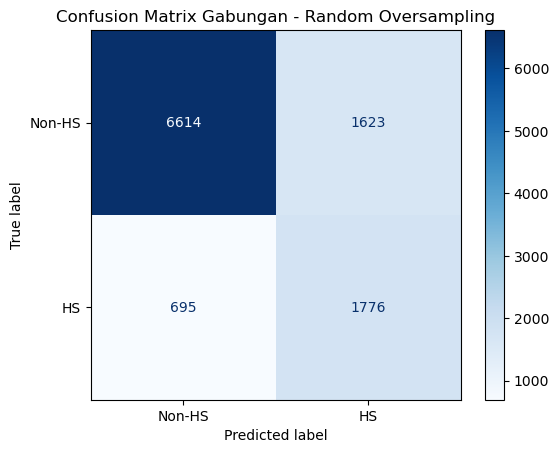

<Figure size 640x480 with 0 Axes>

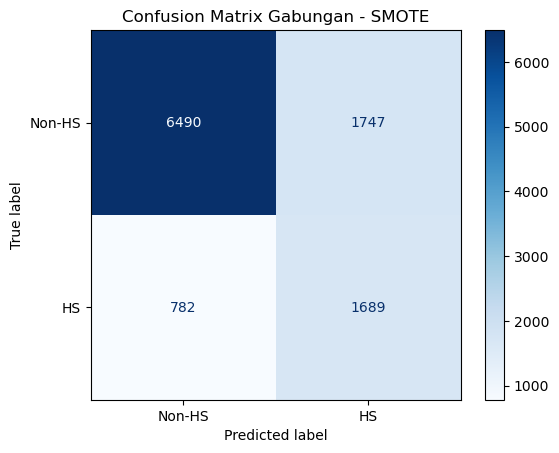

<Figure size 640x480 with 0 Axes>

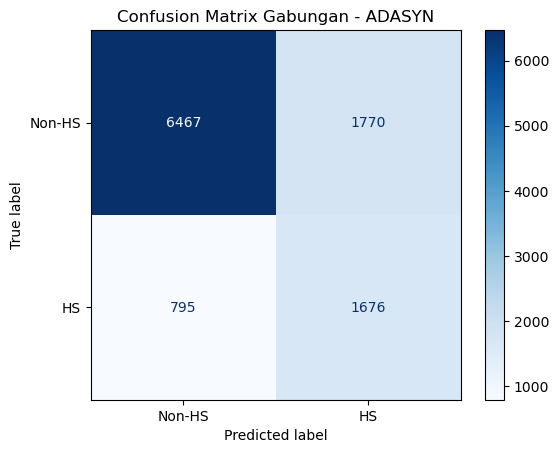


Perbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):
   accuracy  precision    recall  f1_score            technique
0  0.783527   0.525334  0.718729  0.605625  Random Oversampling
1  0.763820   0.492539  0.683532  0.571988                SMOTE
2  0.760456   0.489395  0.678272  0.566909               ADASYN


<Figure size 640x480 with 0 Axes>

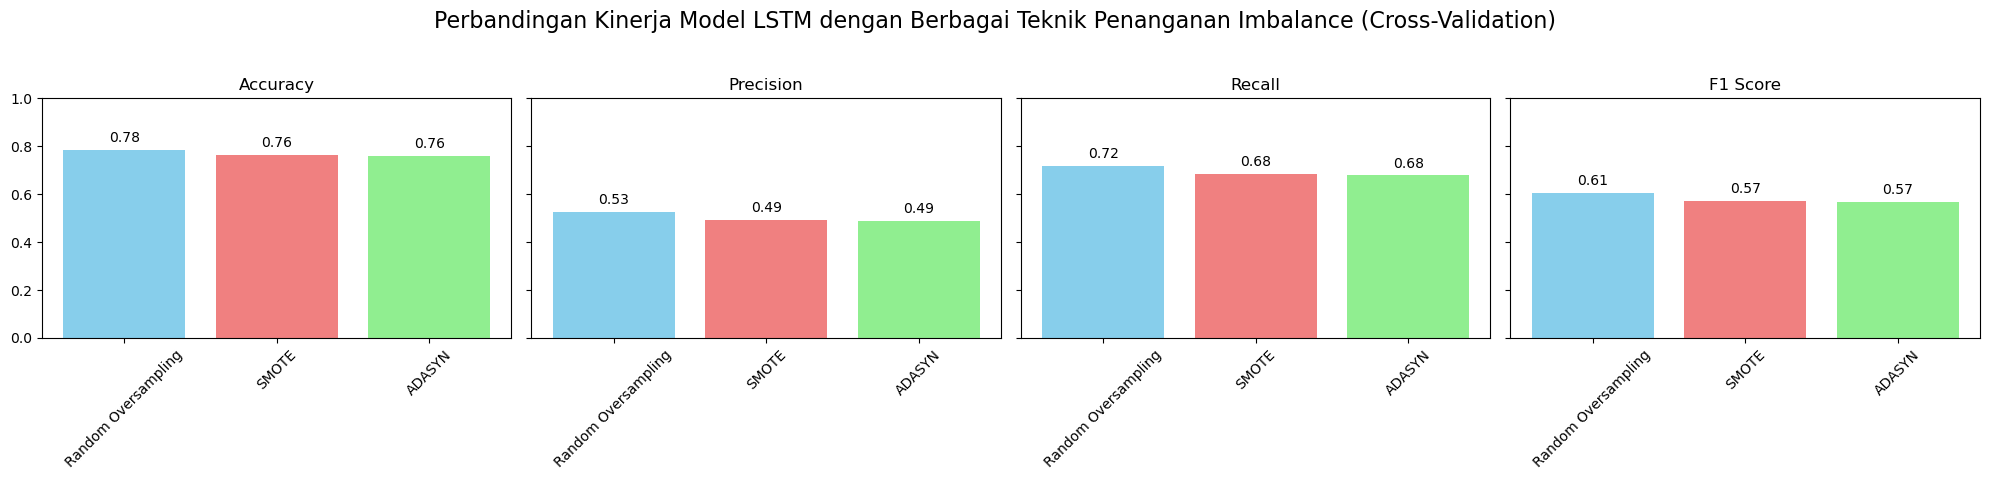

In [18]:
#Implementasi K-Fold Cross-Validation untuk Setiap Teknik Oversampling
n_splits = 5 # Jumlah folds untuk cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

from tqdm import tqdm
import time

all_results = {}
confusion_matrices = {}

# List teknik penanganan imbalance dan inisialisasi objeknya
oversampling_methods = {
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
}

for tech_name, oversampler in oversampling_methods.items():
    fold_metrics = []
    all_y_true = []
    all_y_pred = []

    print(f"\n--- Starting {n_splits}-Fold Cross-Validation for {tech_name} ---")
    start_time = time.time()
    
    # Loop melalui setiap fold Stratified K-Fold
    # skf.split akan membagi X_data_for_cv dan y_data_for_cv (seluruh dataset)
    for fold_idx, (train_idx, val_idx) in tqdm(enumerate(skf.split(X_cv, y_cv)), total=n_splits):
        # Ambil data pelatihan dan validasi untuk fold saat ini (data asli)
        X_train_fold_orig, X_val_fold_orig = X_cv[train_idx], X_cv[val_idx]
        y_train_fold_orig, y_val_fold_orig = y_cv[train_idx], y_cv[val_idx]
        
        X_train_fold_resampled, y_train_fold_resampled = oversampler.fit_resample(X_train_fold_orig, y_train_fold_orig)
        print(f"Fold {fold_idx+1} - Resampled training set distribution ({tech_name}): {Counter(y_train_fold_resampled)}")

        # Latih dan evaluasi model pada fold ini
        metrics = train_and_evaluate_single_fold(
            X_train_fold_resampled, y_train_fold_resampled,
            X_val_fold_orig, y_val_fold_orig, # Evaluasi pada data validasi asli (tidak di-oversample)
            fold_idx,
            tech_name, # Teruskan nama teknik ke fungsi evaluasi
        )

        fold_metrics.append(metrics)
        all_y_true.extend(metrics['y_true'])
        all_y_pred.extend(metrics['y_pred'])

        print(f"Waktu untuk {tech_name}: {time.time() - start_time:.2f} detik")
    
    # Confusion matrix gabungan untuk teknik ini
    cm = confusion_matrix(all_y_true, all_y_pred)
    confusion_matrices[tech_name] = cm

    # Rata-rata metrik
    metric_df = pd.DataFrame([{k: v for k, v in d.items() if k in ['accuracy', 'precision', 'recall', 'f1_score']} for d in fold_metrics])
    avg_metrics = metric_df.mean().to_dict()
    avg_metrics['technique'] = tech_name
    all_results[tech_name] = avg_metrics

    print(f"\nAverage Metrics for {tech_name} across {n_splits} folds:")
    print(avg_metrics)

# Visualisasi confusion matrix per teknik
print("\nVisualisasi Confusion Matrix Gabungan untuk Setiap Teknik Oversampling:")
for tech_name, cm in confusion_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-HS', 'HS'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix Gabungan - {tech_name}')
    plt.show()
    plt.savefig(f"confusion_matrix_{tech_name}.png", dpi=300, bbox_inches='tight')

# Konversi hasil evaluasi ke DataFrame
results_df = pd.DataFrame(list(all_results.values()))
print("\nPerbandingan Metrik Kinerja Model (Rata-rata Cross-Validation):")
print(results_df)

# Plot perbandingan metrik
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), figsize=(20, 5), sharey=True)
fig.suptitle('Perbandingan Kinerja Model LSTM dengan Berbagai Teknik Penanganan Imbalance (Cross-Validation)', fontsize=16)

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(results_df['technique'], results_df[metric], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    for index, row in results_df.iterrows():
        axes[i].text(index, row[metric] + 0.02, f"{row[metric]:.2f}", ha='center', va='bottom')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()